## Calculating distances

In this tutorial, we will calculate distances with projected layers. **Our aim is to find the Euclidean distances from the centroids (midpoints) of all European countries to Helsinki, Finland.** We will calculate the distance between Helsinki and other European countries using a metric projection ([Azimuthal Equidistant -projection](https://proj4.org/operations/projections/aeqd.html)) that gives us the distance in meters. Notice, that this projection is slightly less commonly used, but still useful to know. 

- First, let's import necessary modules and continue working with the European borders:

In [1]:
# Import necessary modules
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point
import matplotlib.pyplot as plt


# Input file that we created on the previous page
fp = r"L2_data/Europe_borders_epsg3035.shp"
    
# Save to disk
data = gpd.read_file(fp)

- Let's create a GeoDataFrame that contains a single Point representing the location of Helsinki, Finland:

In [2]:
# Create the point representing Helsinki (in WGS84)
hki_lon = 24.9417
hki_lat = 60.1666

# Create GeoDataFrame
helsinki = gpd.GeoDataFrame([[Point(hki_lon, hki_lat)]], geometry='geometry', crs={'init': 'epsg:4326'}, columns=['geometry'])

# Print 
print(helsinki)

                    geometry
0  POINT (24.94170 60.16660)


As we can see, it is possible to create a GeoDataFrame directly with one line of code. Notice that, here, we specified the CRS directly by passing the crs as Python dictionary `{'init': 'epsg:4326'}` which is one alternative way to define the CRS. We also told that the `geometry` information is stored in column called `'geometry'` that we actually define with parameter `columns=['geometry']`. 

Next, we need to convert this `GeoDataFrame` to "Azimuthal Equidistant" -projection that has useful properties because all points on the map in that projection are at proportionately correct distances from the center point (defined with parameters `lat_0` and `lon_0`), and all points on the map are at the correct direction from the center point. 

To conduct the transformation, we are going to utilize again [pyproj](https://pyproj4.github.io/pyproj) library which is also good at dealing with "special" projections such as the one demonstrated here.

 - We will create a CRS by passing specific parameters to `Proj()` -object that are needed to construct the [Azimuthal Equidistant projection](https://proj4.org/operations/projections/aeqd.html):
    
    - `proj='aeqd'` refers to *projection specifier* that we determine to be Azimuthal Equidistant ('aeqd')
    - `ellps='WGS84'` refers to the [reference ellipsoid](https://en.wikipedia.org/wiki/Reference_ellipsoid) that is a mathematically modelled (based on measurements) surface that approximates the true shape of the world. World Geodetic System (WGS) was established in 1984, hence the name. 
    - `datum='WGS84'` refers to the [Geodetic datum](https://en.wikipedia.org/wiki/Geodetic_datum) that is a coordinate system constituted with a set of reference points that can be used to locate places on Earth.
    - `lat_0` is the latitude coordinate of the center point in the projection
    - `lon_0` is the longitude coordinate of the center point in the projection

In [3]:
# Define the projection using the coordinates of our Helsinki point (hki_lat, hki_lon) as the center point
# The .srs here returns the text presentation of the projection
aeqd = CRS(proj='aeqd', ellps='WGS84', datum='WGS84', lat_0=hki_lat, lon_0=hki_lon).srs

# Reproject to aeqd projection using Proj4-string
helsinki = helsinki.to_crs(crs=aeqd)

# Print the data
print(helsinki)

# Print the crs
print('\nCRS:\n', helsinki.crs)

                  geometry
0  POINT (0.00000 0.00000)

CRS:
 +proj=aeqd +ellps=WGS84 +datum=WGS84 +lat_0=60.1666 +lon_0=24.9417 +type=crs


As we can see the projection is indeed centered to Helsinki as the 0-position (in meters) in both x and y is defined now directly into the location where we defined Helsinki to be located (you'll understand soon better when seeing the map). 

Next we want to transform the `Europe_borders.shp` data into the desired projection. 

- Let's create a new copy of our GeoDataFrame into a variable called `europe_borders_aeqd`: 

In [4]:
# Create a copy
europe_borders_aeqd = data.copy()

- Let's now reproject our Europer borders data into the Azimuthal Equidistant projection that was centered into Helsinki:

In [5]:
# Reproject to aeqd projection that we defined earlier
europe_borders_aeqd = europe_borders_aeqd.to_crs(crs=aeqd)

# Print 
print(europe_borders_aeqd.head(2))

            TZID                                           geometry
0  Europe/Berlin  POLYGON ((-1057542.597 -493724.802, -1058052.5...
1  Europe/Berlin  POLYGON ((-1216418.435 -1243831.635, -1216378....


Okay, now we can see that the coordinates in `geometry` column are fairly large numbers as they represents the distance in meters from Helsinki to different directions. 

- Let's plot the Europe borders and the location of Helsinki to get a better understanding how our projection has worked out:

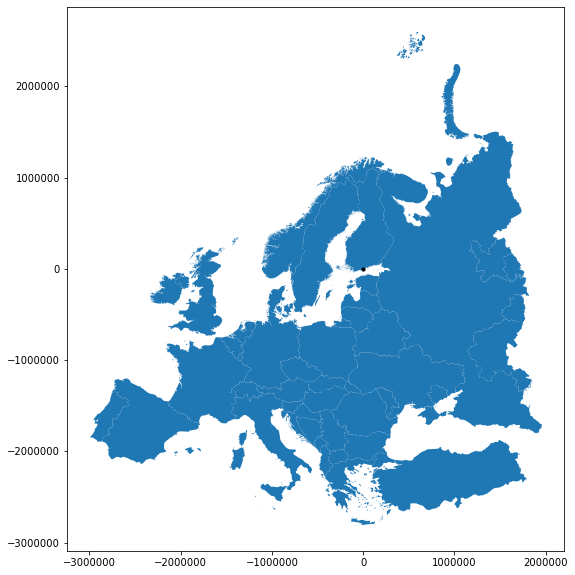

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

# Plot the country borders
europe_borders_aeqd.plot(ax=ax)

# Plot the Helsinki point on top of the borders using the same axis
helsinki.plot(ax=ax, color='black', markersize=10)

As we can see from the map, the projection is indeed centered to Helsinki as the 0-position of the x and y axis is located where Helsinki is positioned. Now the coordinate values are showing the distance from Helsinki (black point) to different directions (South, North, East and West) in meters. 



Next, our goal is to calculate the distance from all countries to Helsinki. To be able to do that, we need to calculate the centroids for all the Polygons representing the boundaries of European countries. 

- This can be done easily in Geopandas by using the `centroid` attribute:

In [7]:
europe_borders_aeqd['centroid'] = europe_borders_aeqd.centroid
print(europe_borders_aeqd.head(2))

            TZID                                           geometry  \
0  Europe/Berlin  POLYGON ((-1057542.597 -493724.802, -1058052.5...   
1  Europe/Berlin  POLYGON ((-1216418.435 -1243831.635, -1216378....   

                            centroid  
0   POINT (-1057718.135 -492420.566)  
1  POINT (-1218235.217 -1242668.590)  


Now we have created a new column called `centroid` that has the Point geometries representing the centroids of each Polygon (in Azimuthal Equidistant projection).

Next, we will calculate the distances between the country centroids and Helsinki. For doing this, we could use `iterrows()` -function that we have used earlier, but here we will demonstrate a more efficient (faster) technique to go through all rows in (Geo)DataFrame by using `apply()` -function. 

The [apply()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) -function can give a big boost in performance over the `iterrows()` and it is the recommendable way of iterating over the rows in (Geo)DataFrames. Here, we will see how to use that to calculate the distance between the centroids and Helsinki. 

 - First, we will create a dedicated function for calculating the distances called `calculate_distance()`:

In [8]:
def calculate_distance(row, dest_geom, src_col='geometry', target_col='distance'):
    """
    Calculates the distance between Point geometries.

    Parameters
    ----------
    dest_geom : shapely.Point
       A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
       A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
       A name of the target column where the result will be stored.

    Returns
    -------
    
    Distance in kilometers that will be stored in 'target_col'.
    """
    
    # Calculate the distances
    dist = row[src_col].distance(dest_geom)

    # Convert into kilometers
    dist_km = dist / 1000

    # Assign the distance to the original data
    row[target_col] = dist_km
    return row

Here, the parameter `row` is used to pass the data from each row of our GeoDataFrame into the function. Other paramaters are used for passing other necessary information for using our function.

- Before using our function and calculating the distances between Helsinki and centroids, we need to get the Shapely point geometry from the re-projected Helsinki center point that we can pass to our function (into the `dest_geom` -parameter. We can use the `loc` -functionality to retrieve the value from specific index and column:

In [9]:
# Retrieve the geometry from Helsinki GeoDataFrame
helsinki_geom = helsinki.loc[0, 'geometry']
print(helsinki_geom)

POINT (0 0)


Now we are ready to use our function with `apply()`. When using the function, it is important to specify the direction of iteration that should be in our case specified with `axis=1`. This ensures that the calculations are done row by row (instead of column-wise).
  
  - When iterating over a DataFrame or GeoDataFrame, apply function is used by following the format `GeoDataFrame.apply(name_of_your_function, param1, param2, param3,  axis=1)`
  
    - Notice that the first parameter is always the name of the function that you want to use **WITHOUT** the parentheses. This will start the iteration using the function you have created, and the values of the row will be inserted into the `row` parameter / attribute inside the function (see above). 

In [10]:
# Calculate the distances using our custom function called 'calculate_distance'
europe_borders_aeqd = europe_borders_aeqd.apply(calculate_distance, dest_geom=helsinki_geom, src_col='centroid', target_col='dist_to_Hki', axis=1)
print(europe_borders_aeqd.head(10))

            TZID                                           geometry  \
0  Europe/Berlin  POLYGON ((-1057542.597 -493724.802, -1058052.5...   
1  Europe/Berlin  POLYGON ((-1216418.435 -1243831.635, -1216378....   
2  Europe/Berlin  POLYGON ((-1194521.639 -571726.459, -1194674.9...   
3  Europe/Berlin  POLYGON ((-1185933.276 -571780.053, -1186040.7...   
4  Europe/Berlin  POLYGON ((-1182416.220 -569097.571, -1183274.4...   
5  Europe/Berlin  POLYGON ((-1172799.401 -565749.439, -1175327.7...   
6  Europe/Berlin  POLYGON ((-1162805.428 -563558.434, -1161240.8...   
7  Europe/Berlin  POLYGON ((-1129053.541 -568388.470, -1129252.5...   
8  Europe/Berlin  POLYGON ((-1109126.533 -570899.989, -1109690.5...   
9  Europe/Berlin  POLYGON ((-703490.147 -664009.792, -703842.631...   

                                        centroid  dist_to_Hki  
0  POINT (-1057718.135423443 -492420.5658204998)  1166.724332  
1  POINT (-1218235.216971495 -1242668.589667922)  1740.207536  
2   POINT (-1194210.789299

Great! Now we have successfully calculated the distances between the Polygon centroids and Helsinki. 😎

- Let's check what is the longest and mean distance to Helsinki from the centroids of other European countries:

In [11]:
# Calculat the maximum and average distance
max_dist = europe_borders_aeqd['dist_to_Hki'].max()
mean_dist = europe_borders_aeqd['dist_to_Hki'].mean()

print("Maximum distance to Helsinki is %.0f km, and the mean distance is %.0f km." % (max_dist, mean_dist))

Maximum distance to Helsinki is 3470 km, and the mean distance is 1177 km.


As we can see, the finns living in the North are fairly far away from all other European countries, as the mean distance to other countries is 1185 kilometers. 

Notice: If you would like to calculate distances between multiple locations across the globe, it is recommended to use [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to do the calculations. [Haversine](https://github.com/mapado/haversine) package in Python provides an easy-to-use function for calculating these
   based on latitude and longitude values.


That's it! During this tutorial we have seen how to calculate distances between locations and using `apply()` -function to iterate over rows more efficiently than using `iterrows()`. 